**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2024**

---

### Series Temporales: 
### Introducción a las Series de tiempo (Examen Media Materia)

---

**Integrantes:** Cristian Keimel y Enzo Manolucos
<br>
<br>
<br>

 ## Problema 1:
 
- Objetivo de este problema: Estudiar la demanda mensual de energia electrica en Victoria. 


- Realice los siguientes gráficos siguiendo la notebook **Visualizacion de datos de polucion de corea.ipynb**

    - Gráfico de radar

    - Gráfico de barra circular

    - Gráfico de ploteo radial

 - Diga cual de los trés gráficos provee mejor información visual, y arme una única imagen con todos los gráficos realizados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from PIL import Image

In [2]:
plt.style.use('ggplot')
color = sns.color_palette().as_hex()

In [3]:
df = pd.read_csv('../Data/vic_elec.csv')
df.head()

Time       Demand  Temperature        Date  Holiday
0  2011-12-31T13:00:00Z  4382.825174        21.40  2012-01-01     True
1  2011-12-31T13:30:00Z  4263.365526        21.05  2012-01-01     True
2  2011-12-31T14:00:00Z  4048.966046        20.70  2012-01-01     True
3  2011-12-31T14:30:00Z  3877.563330        20.55  2012-01-01     True
4  2011-12-31T15:00:00Z  4036.229746        20.40  2012-01-01     True

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [5]:
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%dT%H:%M:%SZ')
df.set_index('Time', inplace=True)

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index,
                         y=df['Demand'],
                         mode='lines'
                         ))
fig.update_layout(
    title='Demanda de la energía eléctrica de Victoria, Australia',
    xaxis_title='Tiempo',
    yaxis_title='Demanda [MW]'
    )
fig.show()

### Preparación de datos

Para poder realizar los gráficos se debe crear un nuevo dataframe mediante el método ``.pivot``. Esto nos permite acomodar los datos de forma tal que los meses sean los indices y las columnas los años. Cada valor se completara con el valor medio de la demanda energética de cada mes y año. Para que los gráficos queden lo más completos se debe replicar una nueva fila al final con el valor correspondiente a Enero. También se relleno los valores nulos con 1. Estos valores no seran observables pero ayudaran a poder crear los gráficos

In [7]:
df['Year'] = df.index.year
df['Month'] = df.index.month

In [8]:
df_grouped = df.groupby(['Year', 'Month']).agg({'Demand': 'mean'}).reset_index()
df_pivot = df_grouped.pivot(index='Month', columns='Year', values='Demand')

# Completo con una fila más, con los mismos datos de Enero y relleno los valores nulos con 1
df_pivot.loc[13] = df_pivot.loc[1] 
df_pivot = df_pivot.fillna(1)

In [9]:
months = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

### Gráfico de radar

In [10]:
fig = go.Figure()

for year in df_pivot.columns:
    fig.add_trace(go.Scatterpolar(
        name = str(year),
        r = df_pivot[year],
        theta = months + ['Enero'], 
        #mode='lines',
        #fill='toself',
        #fillcolor=None
        ))

fig.update_layout(polar = dict(radialaxis_title="Demanda [MW]",
                               radialaxis = dict(visible = True, range=[4200, 5200]),
                               angularaxis = dict(rotation=-90)),
                    title='Demanda de la Energía Eléctrica por Mes',
                  showlegend=True, 
                  width=1200, 
                  height=720)
fig.show()
pio.write_image(fig, '1_radar.png')

### Gráfico de barra circular

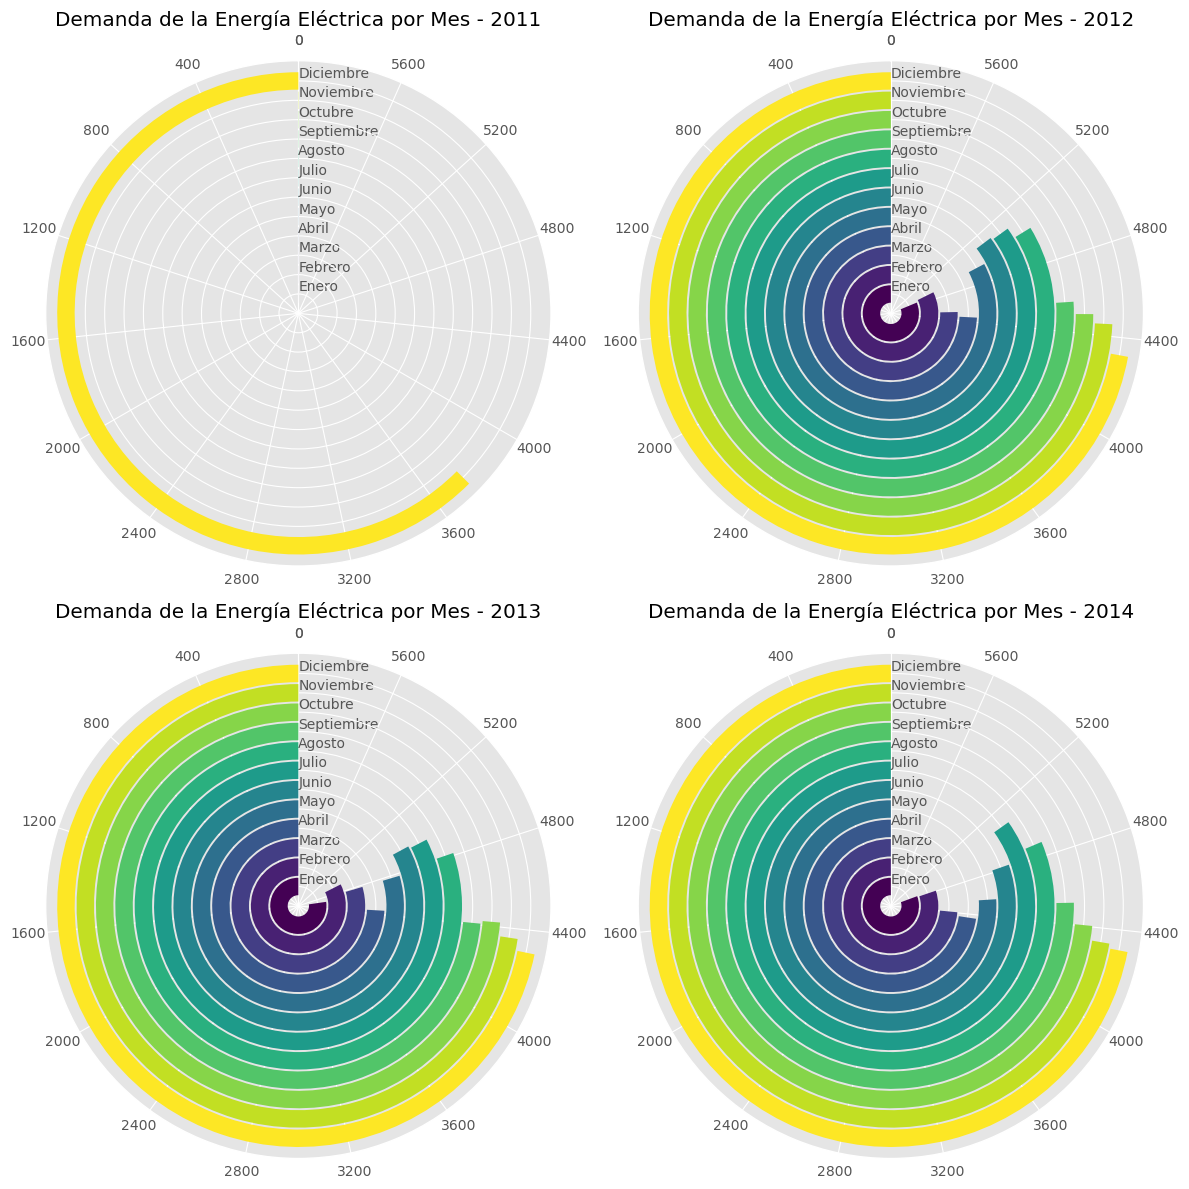

In [11]:
labels = [0, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400, 4800, 5200, 5600, 0]
cmap = plt.get_cmap('viridis')  # Obtener la paleta 'viridis'
max_value = 6000

fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': 'polar'})
axs = axs.flatten()

for idx, (year, ax) in enumerate(zip(df_pivot.columns, axs)):
    for i in range(12):  
        value = df_pivot[year].loc[i + 1]
        color = cmap(i / 11)  
        ax.barh(i + 1, value * 2 * np.pi / max_value, height=0.9, color=color)

    ax.set_theta_zero_location('N')  
    ax.set_theta_direction(1)        
    ax.set_rlabel_position(0)        
    ax.set_rgrids(range(1, 13), labels=months) 
    ax.set_title(f'Demanda de la Energía Eléctrica por Mes - {year}')
    ax.set_thetagrids(range(0, 384, 24), labels=labels)

plt.tight_layout()
plt.savefig('2_barra_circular.png')
plt.show()


### Gráfico de ploteo radial

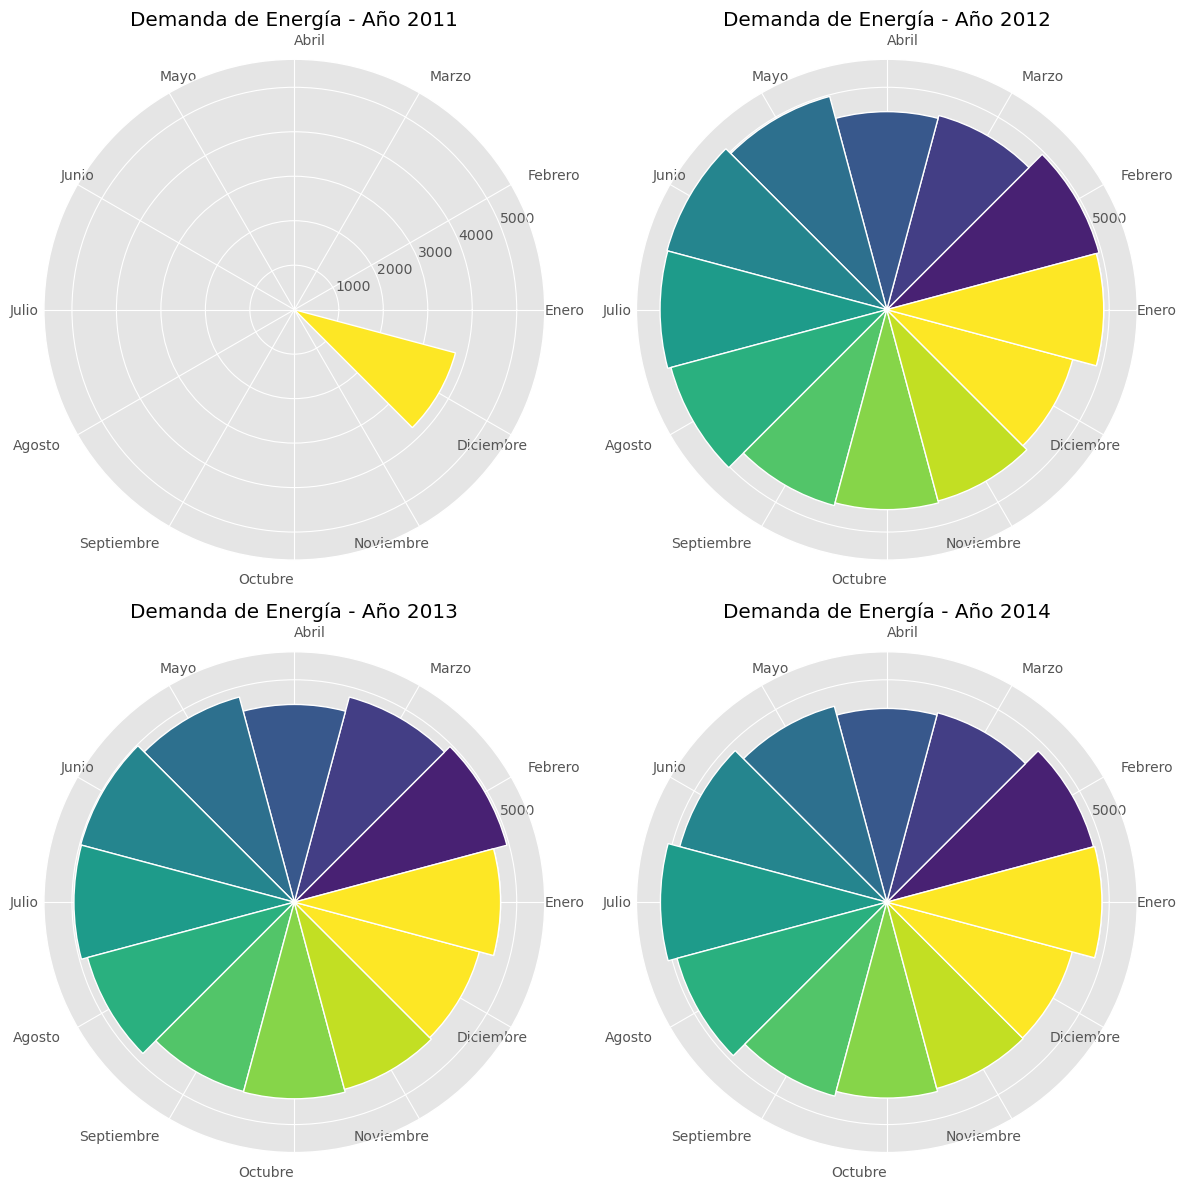

In [12]:
cmap = plt.get_cmap('viridis')
max_value = df_pivot.max().max()

fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(projection='polar'))
axs = axs.flatten()

for idx, (year, ax) in enumerate(zip(df_pivot.columns, axs)):
    values = df_pivot[year].drop(13, errors='ignore')
    angles = np.linspace(0, 2 * np.pi, len(months), endpoint=False).tolist()
    angles += angles[:1]  
    values = values.tolist()
    values += values[:1]  

    width = 2 * np.pi / len(months)  
    lowerLimit = 0  

    bars = ax.bar(angles, values, width=width, align='center', bottom=lowerLimit, linewidth=1, edgecolor="white")

    for i, bar in enumerate(bars):
        bar.set_facecolor(cmap(i / (len(months) - 1)))  # Color basado en el índice del mes

    ax.set_ylim(0, max_value * 1.1)  
    ax.set_xticks(angles[:-1])  
    ax.set_xticklabels(months, fontsize=10)

    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    ax.set_title(f'Demanda de Energía - Año {year}')

plt.tight_layout()
plt.savefig('3_ploteo_radial.png')
plt.show()


### Conclusión

- Gráfico de radar: muestra cómo varían las demandas a lo largo de los mese en un formato que adopta una figura geométrica. Muestra de forma clara los patrones y ciclos que se repiten en los años
- Gráfico de barra circular: cada barra representa la demanda por mes, donde mientras más complete un giro completo, más consumo tienen. Muestra que mes tiene más consumo de forma clara
- Gráfico de ploteo radial: utiliza las coordenadas polares para mostrar la demanda en cada mes, creciendo en área segun el consumo. El comparar los tamaños de cada mes se puede ver cual consume más que otro

Para la visualización de la demanda mensual de energía eléctrica, el gráfico de ploteo radial proporciona mejor información visual. Permite una comparación efectiva entre los meses y destaca las tendencias de manera intuitiva

Finalmente se combinan los tres gráficos en una sola imagen

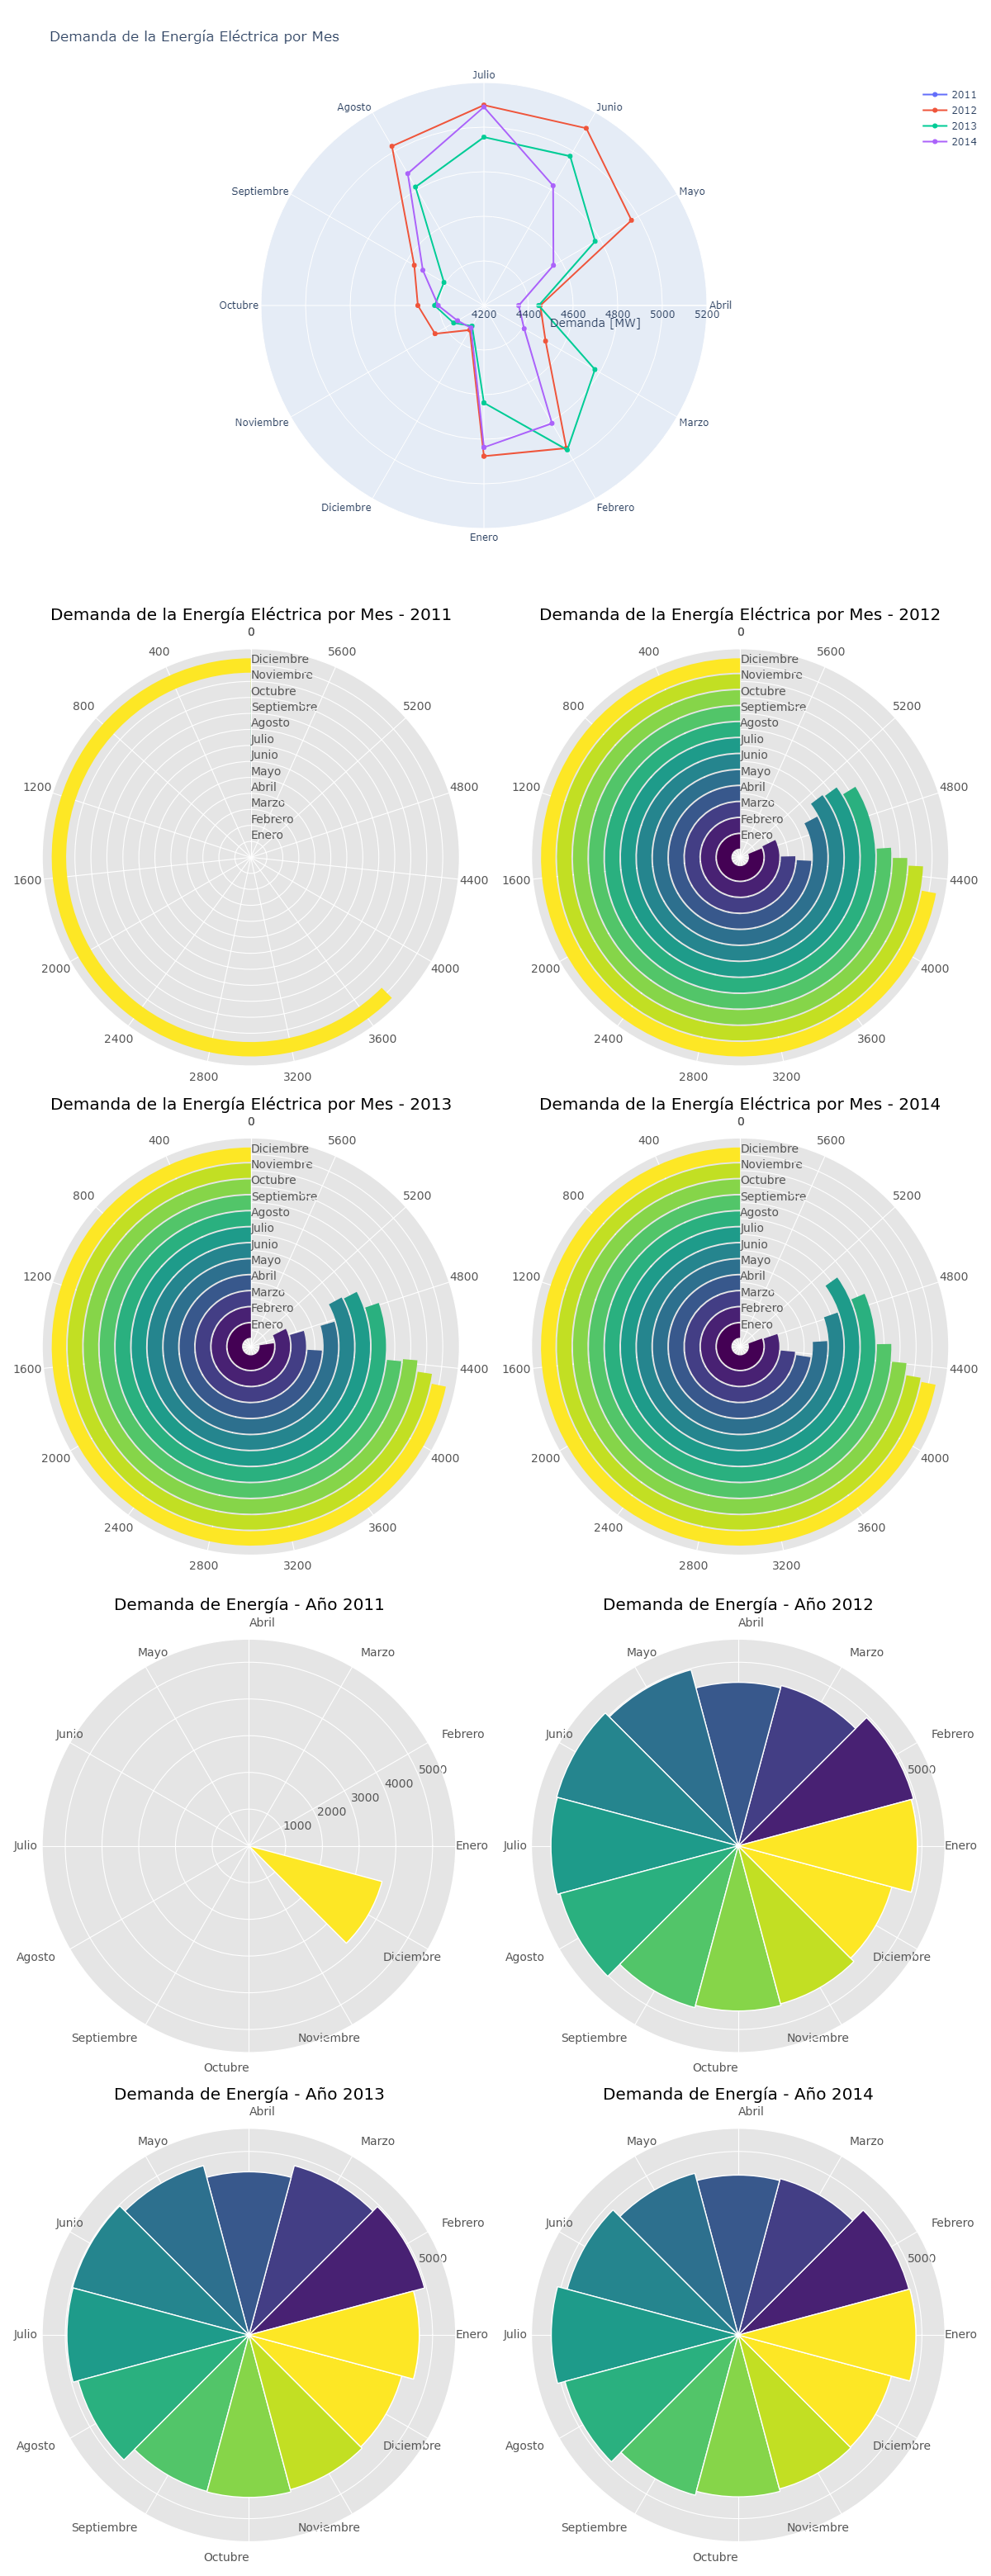

In [13]:
img1 = Image.open('1_radar.png')
img2 = Image.open('2_barra_circular.png')
img3 = Image.open('3_ploteo_radial.png')

combined_width = max(img1.width, img2.width, img3.width)
combined_height = img1.height + img2.height + img3.height
combined_img = Image.new('RGB', (combined_width, combined_height))

combined_img.paste(img1, (0, 0))
combined_img.paste(img2, (0, img1.height))
combined_img.paste(img3, (0, img1.height + img2.height))
display(combined_img)
#combined_img.save('combined_image.png')

## Problema 2:
 
- Objetivo de este problema: Realizar descomposiciones en tendencia y estacionalidad aditiva y multiplicativa (seasonal_decompose) para los gases de madrid 'NO_2' y 'CO'.  

- Dar una opinion de lo observado.

Se importan las librerías necesarias

In [14]:
# importando librerias relevantes

import os
import math
import itertools
import warnings
from collections import defaultdict
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

%matplotlib inline 

Se crea una función para evaluar estacionariedad y de descomposición en componentes

In [15]:
# funcion para evaluar la estacionariedad (Dickey-Fuller Test)

def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [16]:
# Descomposicion en componentes y evaluación de estacionariedad

def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

Como los datos estan separados en varios archivos, hay que unirlos y crear un dataframe

In [17]:
# importando datasets

path = 'csvs_per_year'
files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]
df = pd.concat((pd.read_csv(file) for file in files), sort=False)
df = df.groupby(['date']).agg('mean')
df.index = pd.DatetimeIndex(data= df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151896 entries, 2001-01-01 01:00:00 to 2018-05-01 00:00:00
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   BEN      151867 non-null  float64
 1   CO       151868 non-null  float64
 2   EBE      151867 non-null  float64
 3   MXY      82190 non-null   float64
 4   NMHC     151868 non-null  float64
 5   NO_2     151868 non-null  float64
 6   NOx      92716 non-null   float64
 7   OXY      82190 non-null   float64
 8   O_3      151868 non-null  float64
 9   PM10     151837 non-null  float64
 10  PXY      82185 non-null   float64
 11  SO_2     151868 non-null  float64
 12  TCH      151869 non-null  float64
 13  TOL      151867 non-null  float64
 14  station  151896 non-null  float64
 15  PM25     124629 non-null  float64
 16  NO       64241 non-null   float64
 17  CH4      5087 non-null    float64
dtypes: float64(18)
memory usage: 22.0 MB


In [18]:
# seteamos la freq del indice por horas
df = df.asfreq('h')
print(df.index.freq)

<Hour>


In [19]:
# se verifica que el indice esté completo

(df.index == pd.date_range(start=df.index.min(),
                              end=df.index.max(),
                              freq=df.index.freq)).all()

True

#### Análisis de NO_2

Primero se buscan los datos faltantes

In [20]:
missing_values = df['NO_2'].isnull().sum()
print(f"Valores faltantes en la columna: {missing_values}")

Valores faltantes en la columna: 28


Al ser pocos los datos faltatnes, comparados con el total, se decide completar con la media de los mismos

In [21]:
# son pocos los faltantes en comparacion con el dataset. Llenamos los faltantes con la media de la columna
df_NO2 = df[['NO_2']].copy()
df_NO2 = df_NO2.fillna(df_NO2.mean())
# df_NO2.head()

El primer gráfico muestra los niveles de NO_2 por hora, día y mes

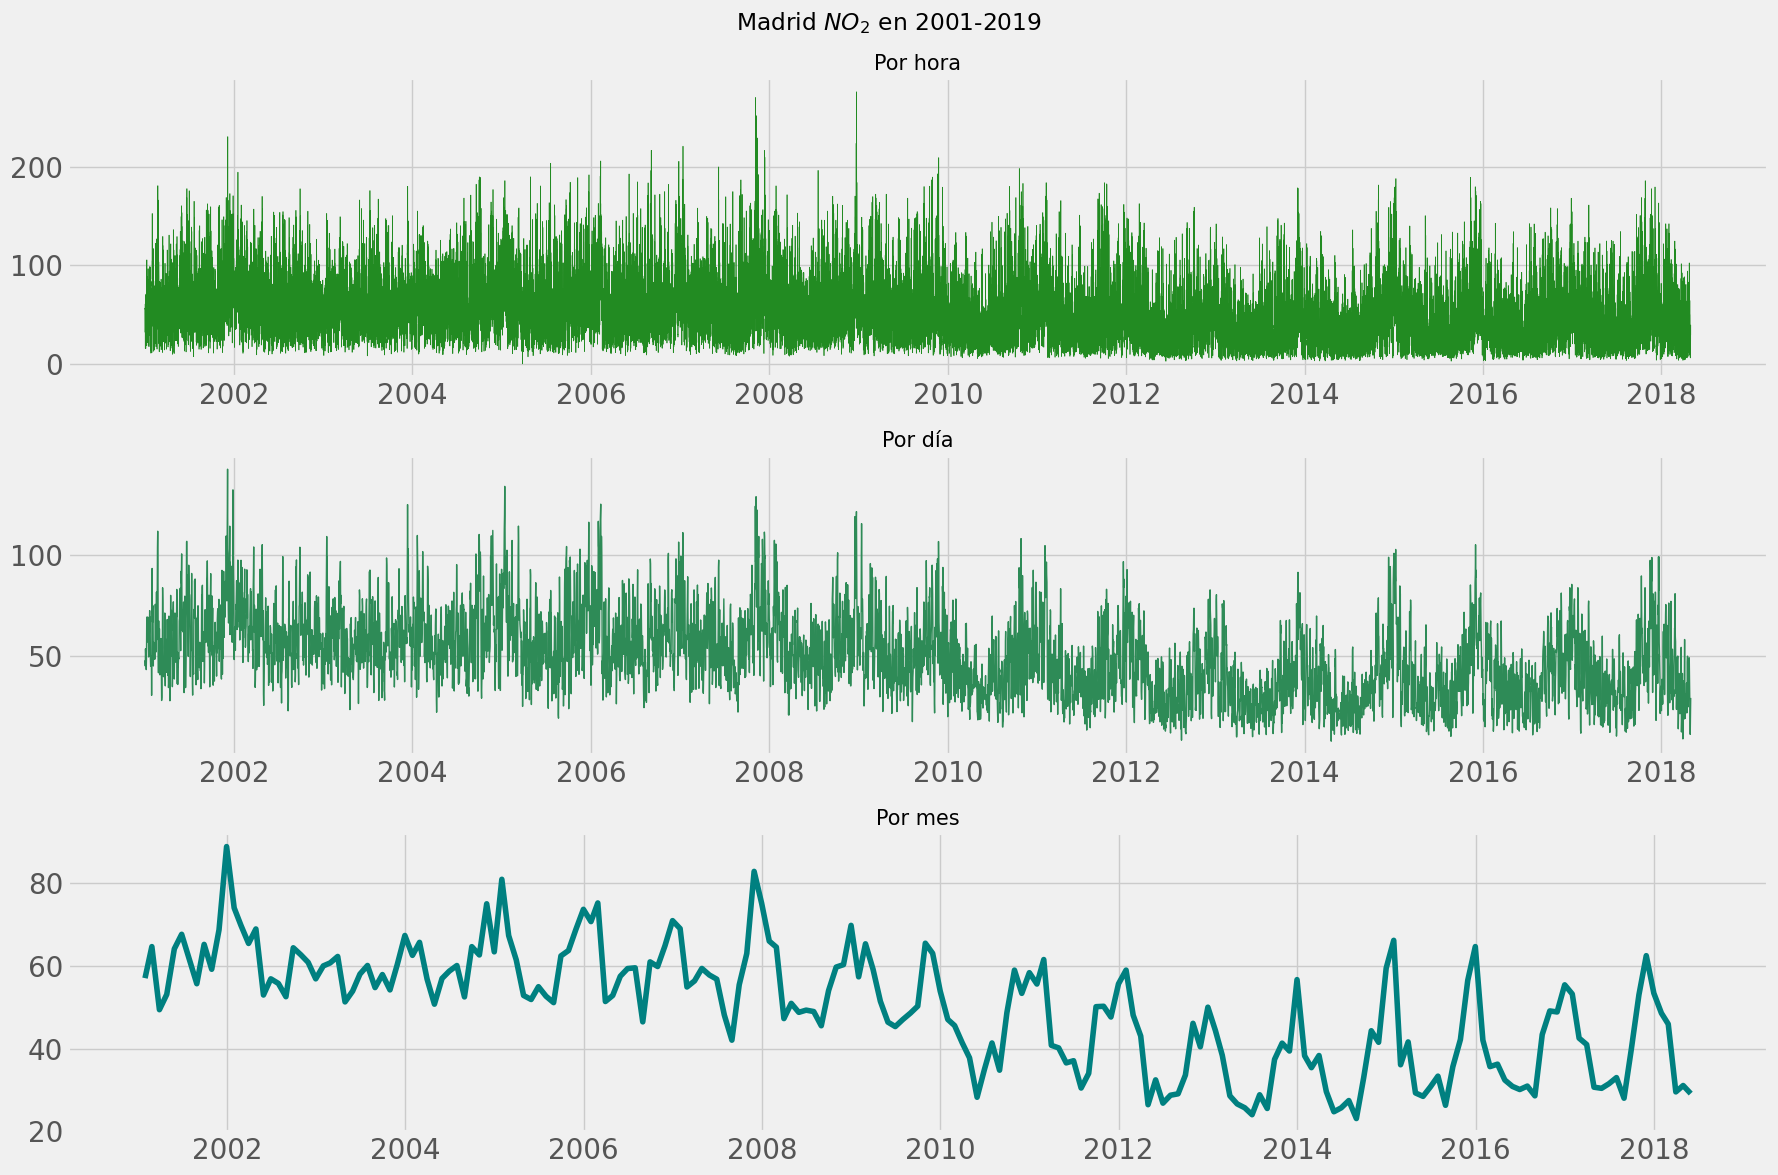

In [22]:
# se plotean los niveles de NO_2 por hora (dataset original), por dia y por mes

monthly_NO2 = df_NO2.resample('ME').mean()
daily_NO2 = df_NO2.resample('D').mean()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))

# por hora
axes[0].plot(df_NO2, color='forestgreen', lw=0.5)
axes[0].set_title('Por hora', fontsize=15)

# por  dia
axes[1].plot(daily_NO2, color='seagreen', lw=1)  # Reemplaza 'df_2' y 'column_name' con tu DataFrame y columna
axes[1].set_title('Por día', fontsize=15)

# por mes
axes[2].plot(monthly_NO2, color='teal')  # Reemplaza 'df_3' y 'column_name' con tu DataFrame y columna
axes[2].set_title('Por mes', fontsize=15)

# Mostrar el gráfico
plt.suptitle('Madrid $NO_2$ en 2001-2019')
plt.tight_layout()
plt.show()

Los siguientes gráficos muestra la descomposición aditiva y multiplicativa

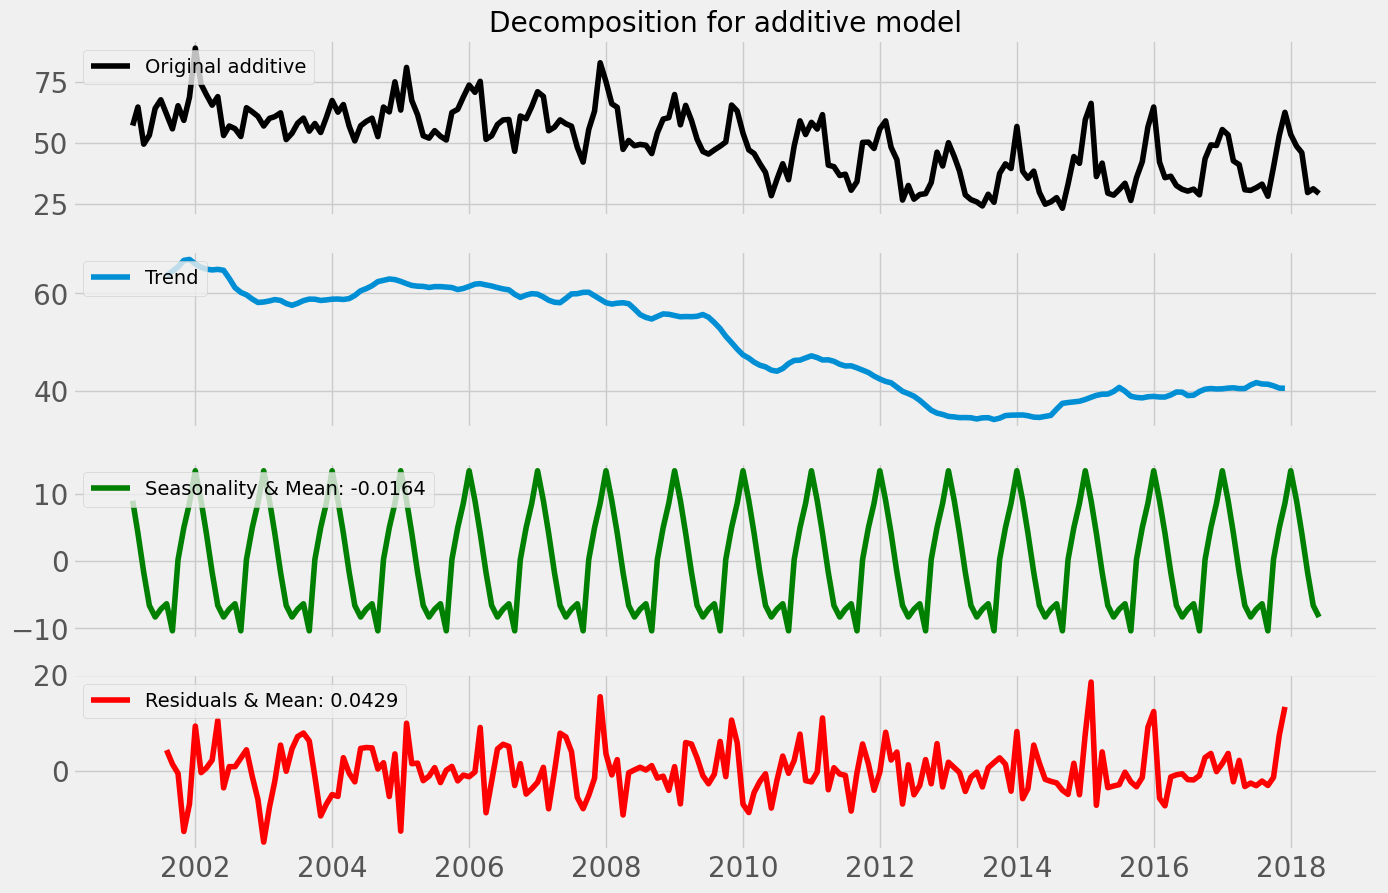

Result: Non-Stationary (H0: non-stationary, p-value: 0.714)


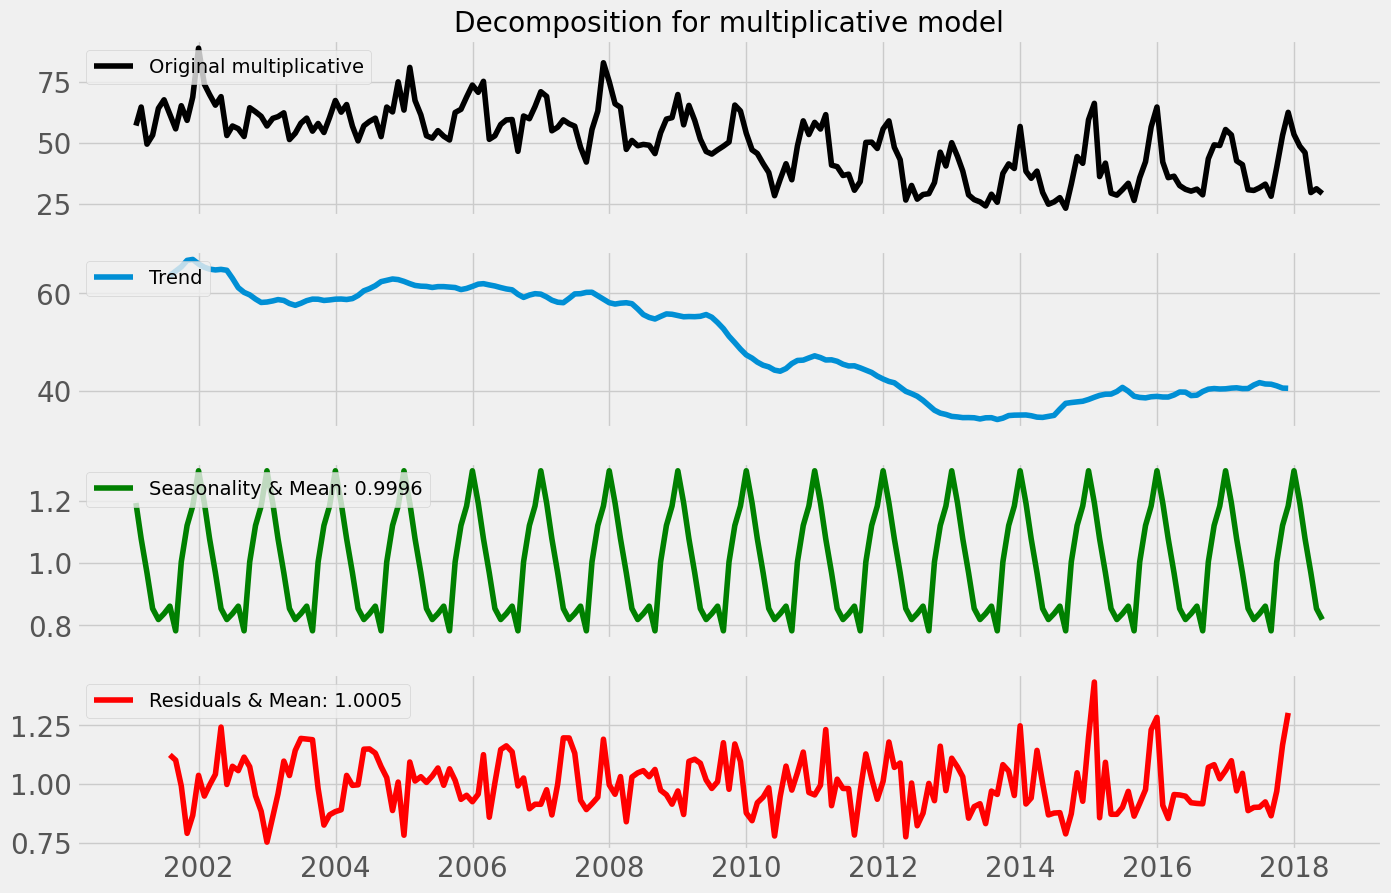

Result: Non-Stationary (H0: non-stationary, p-value: 0.714)


In [23]:
# utilizamos el dataset resampleado por meses
for model in ["additive", "multiplicative"]:
    ts_decompose(monthly_NO2, model,stationary=True)

La despomposición aditiva muestra lo siguiente:
- Componente original: incluye tendencia, estacionalidad y ruido
- Tendencia: se puede observar como disminuye a lo largo de los años, aumentando un poco en los últimos
- Estacionalidad: se puede observar un patrón cíclico regular
- Residuos: no se pueden observar patrones 

La descomposición multiplicativa muestra:
- Componente original: implica que las variaciones estacionales se multiplican con la tendencia
- Tendencia: como el anterior caso, disminuye a lo largo de los años y se estabiliza en los últimos
- Estacionalidad: son proporcionales a la tendencia
- Residuos: fluctua alrededor de un valor medio de 1 

En ambos casos el **test de estacionariedad** indicó que es **no estacionario** 

La serie original parece tener una estacionalidad con una magnitud constante en el tiempo, por lo tanto el método aditivo seria el más apropiado en este caso. Vemos que la media de la estacionalidad y los residuales son cercanos a 0 en el método aditivo, y cercaanos a 1 en el método multiplicativo, lo que confirma la sospecha inicial.

Los residuales cercanos a 0 significa que la descomposición ha captado bien la tendencia y la estacionalidad, dejando solo un error estocástico.

#### Análisis de CO

Primero se buscan los datos faltantes

In [24]:
missing_values = df['CO'].isnull().sum()
print(f"Valores faltantes en la columna: {missing_values}")

Valores faltantes en la columna: 28


Al ser pocos los datos faltatnes, comparados con el total, se decide completar con la media de los mismos

In [25]:
# son pocos los faltantes en comparacion con el dataset. Llenamos los faltantes con la media de la columna
df_CO = df[['CO']].copy()
df_CO = df_CO.fillna(df_CO.mean())
# df_NO2.head()

El primer gráfico muestra los niveles de $CO$ por hora, día y mes

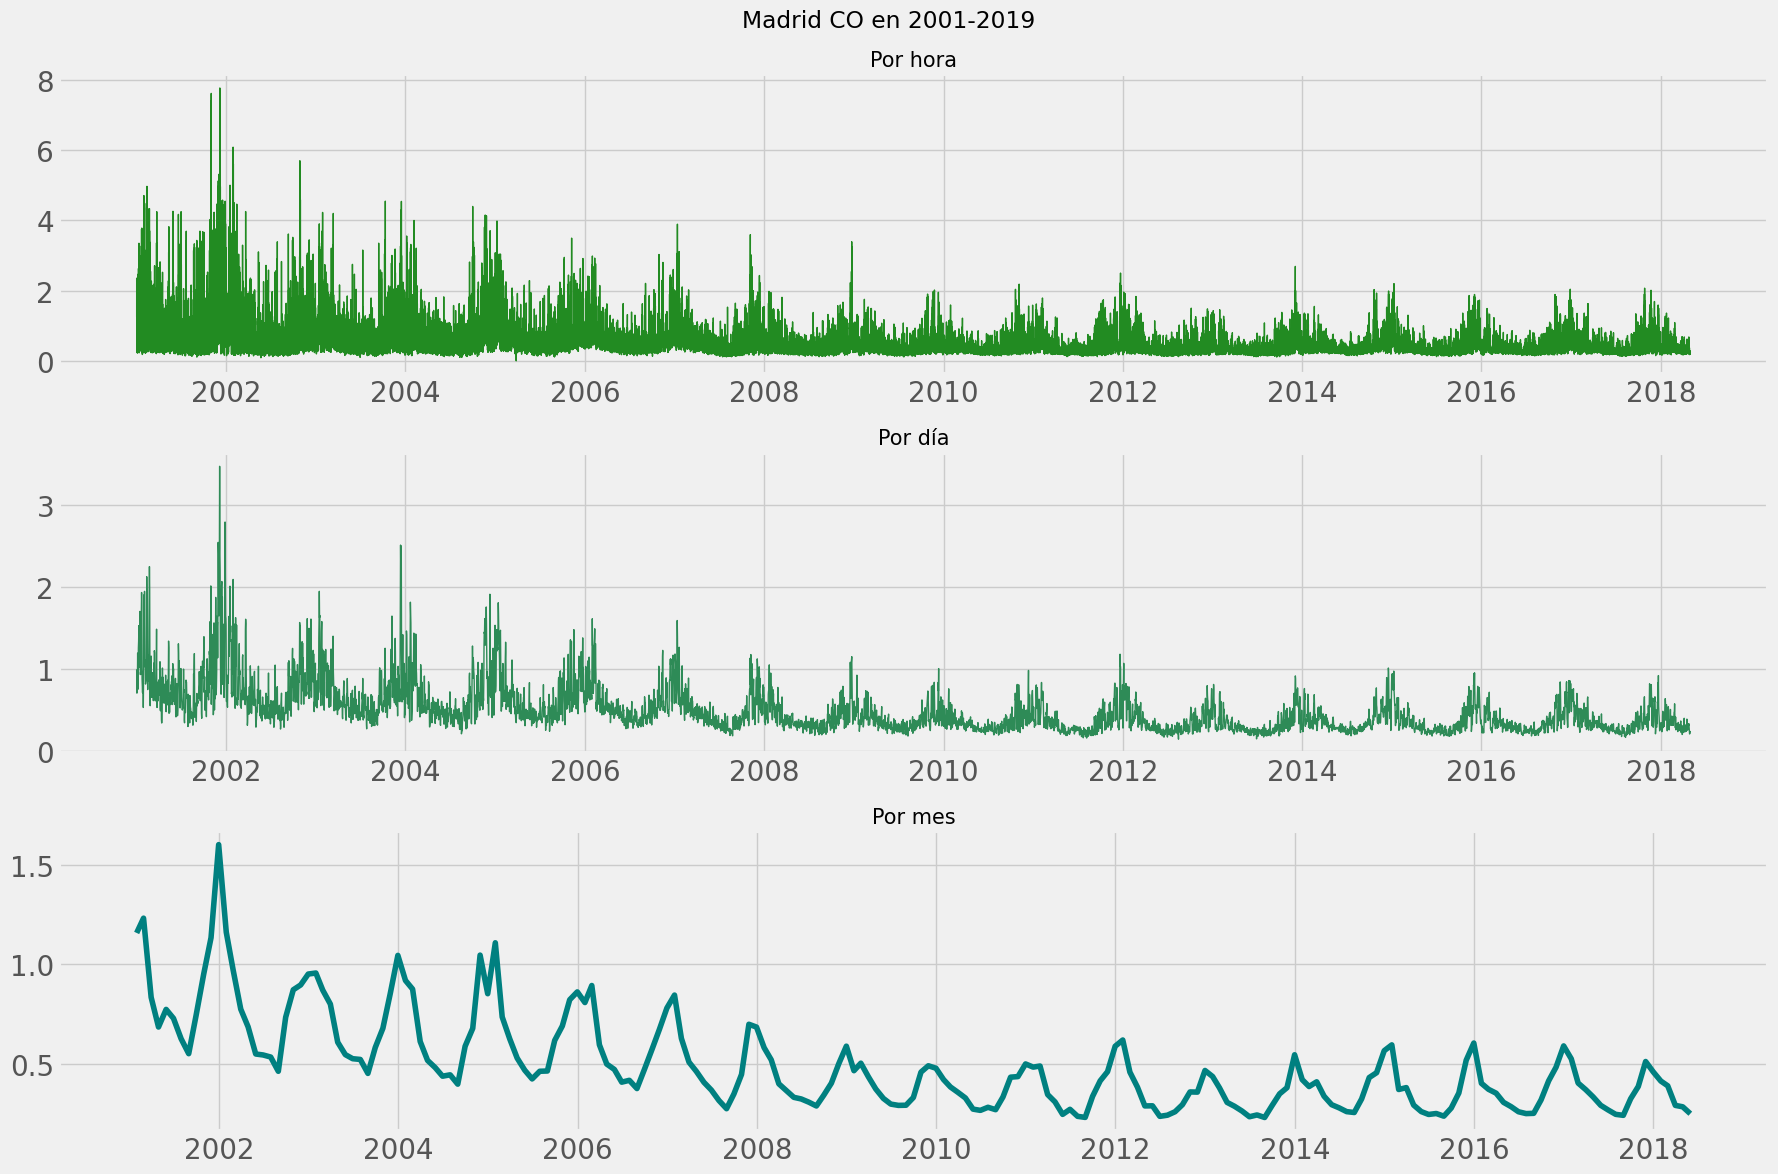

In [26]:
# se plotean los niveles de CO por hora (dataset original), por dia y por mes

monthly_CO = df_CO.resample('ME').mean()
daily_CO = df_CO.resample('D').mean()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))

# por hora
axes[0].plot(df_CO, color='forestgreen', lw=1)
axes[0].set_title('Por hora', fontsize=15)

# por dia
axes[1].plot(daily_CO, color='seagreen', lw=1)  # Reemplaza 'df_2' y 'column_name' con tu DataFrame y columna
axes[1].set_title('Por día', fontsize=15)

# por mes
axes[2].plot(monthly_CO, color='teal')  # Reemplaza 'df_3' y 'column_name' con tu DataFrame y columna
axes[2].set_title('Por mes', fontsize=15)
# axes[2].legend(loc='upper left')

# Mostrar el gráfico
plt.suptitle('Madrid CO en 2001-2019')
plt.tight_layout()
plt.show()

Los siguientes gráficos muestra la descomposición aditiva y multiplicativa

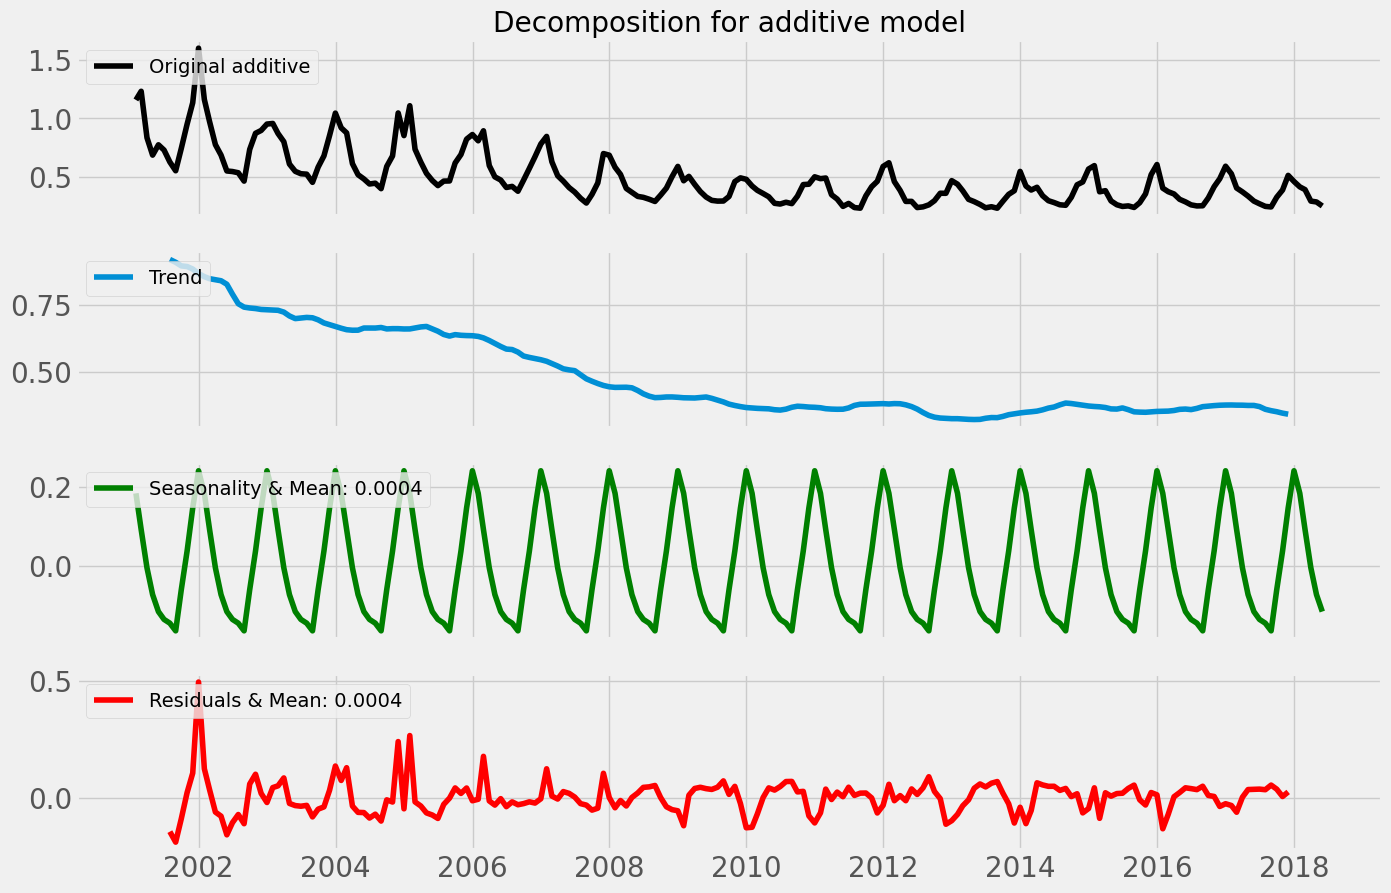

Result: Stationary (H0: non-stationary, p-value: 0.0)


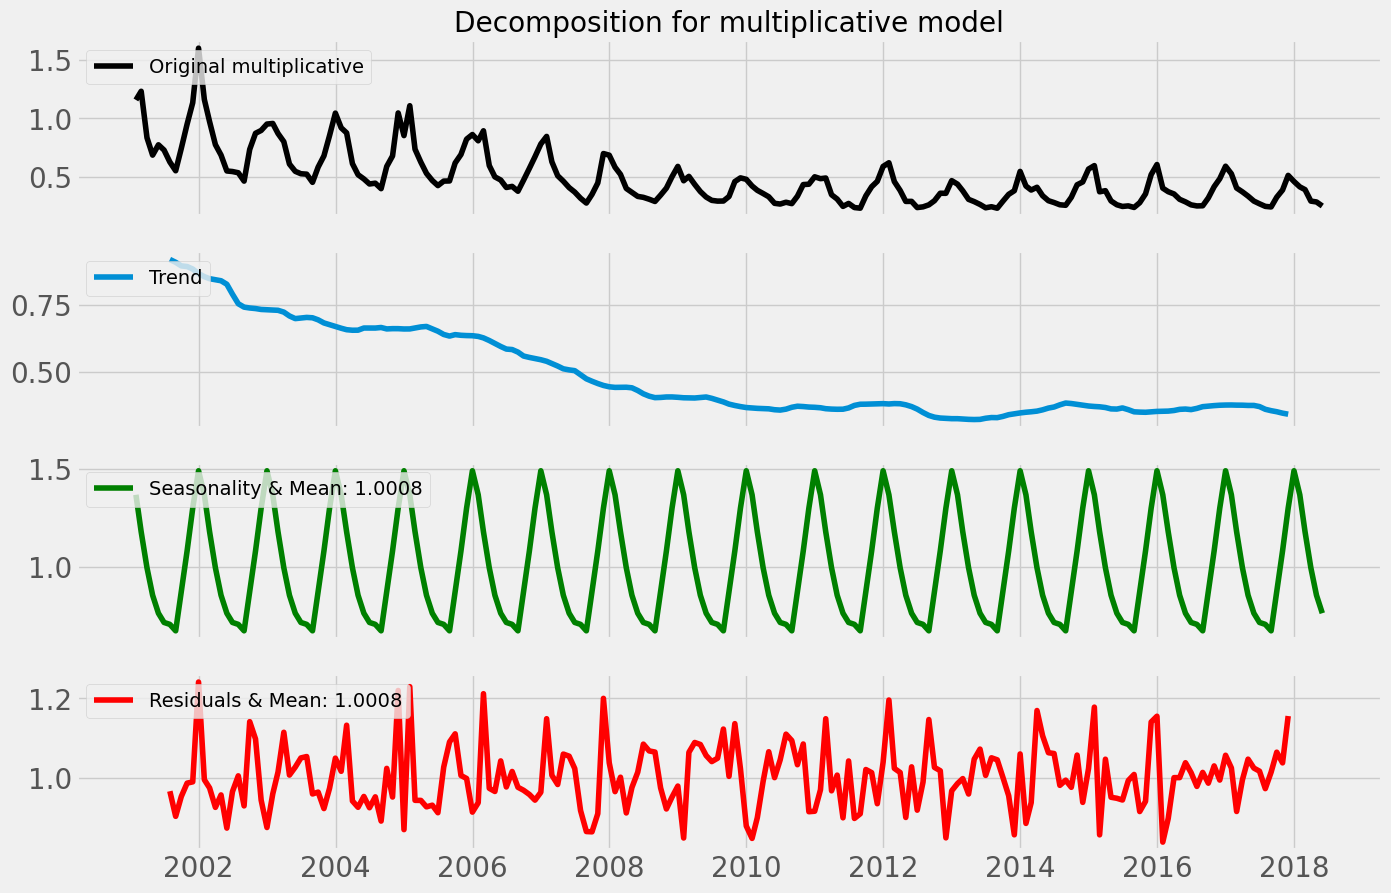

Result: Stationary (H0: non-stationary, p-value: 0.0)


In [27]:
# utilizamos el dataset resampleado por meses
for model in ["additive", "multiplicative"]:
    ts_decompose(monthly_CO, model,stationary=True)

La despomposición aditiva muestra lo siguiente:
- Componente original: tiene fluctuaciones más controladas y valores más pequeños
- Tendencia: se puede observar como disminuye a lo largo de los años
- Estacionalidad: se puede observar un patrón regular y amplitud reducida
- Residuos: se puede observar una gran variabilidad al inicio pero disminuye en los últimos años

La descomposición multiplicativa muestra: 
- Componente original: implica que las variaciones estacionales se multiplican con la tendencia
- Tendencia: como el anterior caso, disminuye a lo largo de los años
- Estacionalidad: son proporcionales a la tendencia
- Residuos: fluctua alrededor de un valor medio de 1 

En ambos casos el **test de estacionariedad** indicó que es **estacionario**.

En este caso, pareciera como si los picos y valles se amplifican cuando los valores de la serie son altos. La magnitud de la estacionalidad parece decrecer con la tendencia, que es a la baja. Esto sugiere que la descompocisión multiplicativa es mas apropiada en este caso.

Sin embargo, las medias de la estacionalidad y los residuales de la descompocisión aditiva son muy cercanos a 0 y los de la multiplicativa muy cercanos a 1. Esto indica que la descompocisión aditiva pudo captar mejor la estacionalidad de la serie.

## Problema 3:
 
- Objetivo de este problema: Realizar suavizado exponencial, suavizado de Holt y suavizado de Holt-Winter  para los gases de madrid 'NO_2' y 'CO'. 

- Encontrar los parámetros generando un set de validación y MSE. 

- Predecir usando TODA la serie (train mas validacion) y comparar con TEST . 

- Plotear la serie completa y la prediccion para observar el comportamiento de cada uno de los suavizados.

- Dar una opinion de la bondad del método para estas series. 

Se definen las funciones para tres variantes del modelo de suavizado exponencial 

In [28]:
# Single Exponential Smoothing 

def ses_optimizer(train, val, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        #print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae
    


# Double Exponential Smoothing
def des_optimizer(train, val, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(val, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            #print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae



# Triple Exponential Smoothing (Holt-Winters)
def tes_optimizer(train, val, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        #print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

#### Análisis NO_2

In [29]:
# se define como train al 70% de los datos, como test el 25% y como validacion el 5%

train = round(len(monthly_NO2) * 0.7)
val = round(len(monthly_NO2) * 0.25 + train)
step_NO2 = round(len(monthly_NO2) * 0.25)

train_NO2 = monthly_NO2[:train]
val_NO2 = monthly_NO2[train : val]
test_NO2 = monthly_NO2[val:]

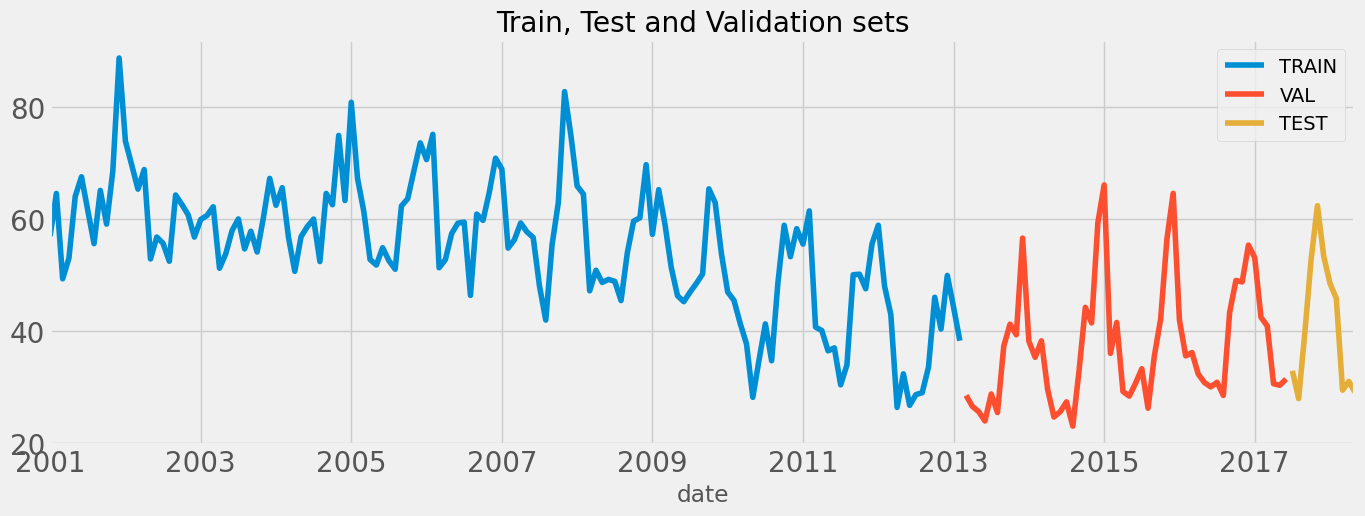

In [30]:
plt.figure(figsize=(15,5))
train_NO2["NO_2"].plot(legend=True, label="TRAIN")
val_NO2["NO_2"].plot(legend=True, label="VAL")
test_NO2["NO_2"].plot(legend=True, label="TEST")    
plt.title("Train, Test and Validation sets")
plt.show()

#### Suavizado Exponencial Simple (SES) para NO_2

In [31]:
def plot_prediction(y_pred, label):
    plt.figure(figsize=(15,5), dpi=100)
    train_NO2["NO_2"].plot(legend=True, label="TRAIN")
    val_NO2["NO_2"].plot(legend=True, label="VAL")
    test_NO2["NO_2"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test, Validation and Predicted Using "+label)
    plt.show()

In [32]:
alphas = np.arange(0.01, 1, 0.01)
# best_alpha, best_mae = ses_optimizer(train_NO2, val_NO2, alphas, step_NO2)

In [33]:
# best_alpha: 0.99 best_mae: 8.8015
best_alpha =  0.99 

In [34]:
train_val_NO2 = monthly_NO2[:val]

ses_model = SimpleExpSmoothing(train_val_NO2).fit(smoothing_level=best_alpha)
y_pred_SES = ses_model.forecast(11)


# grafico suavizado simple
# plot_prediction(y_pred_SES, "SES para NO2")

#### Suavizado Exponencial Doble (suavizado de Holt) para NO_2

In [35]:
alphas = np.arange(0.01, 1, 0.01)
betas = np.arange(0.01, 1, 0.01)

# best_alpha, best_beta, best_mae = des_optimizer(train_NO2, val_NO2, alphas, betas, step_NO2)

In [36]:
# best_alpha: 0.06 best_beta: 0.8 best_mae: 8.0495
best_alpha = 0.06 
best_beta = 0.8 

In [37]:
des_model = ExponentialSmoothing(train_val_NO2, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred_H = des_model.forecast(11)

In [38]:
# grafico suavizado doble

# plot_prediction(y_pred_H, "Holt para NO2")

#### Suavizado Exponencial Triple (suavizado de Holt-Winters) para NO_2

In [39]:
alphas = betas = gammas = np.arange(0.01, 1, 0.05)
abg = list(itertools.product(alphas, betas, gammas))

# best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train_NO2, val_NO2, abg, step_NO2) 

In [40]:
# best_alpha: 0.21 best_beta: 0.51 best_gamma: 0.11 best_mae: 3.8719
best_alpha = 0.21 
best_beta = 0.51 
best_gamma = 0.11 

In [41]:
tes_model = ExponentialSmoothing(train_val_NO2, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred_HW = tes_model.forecast(11)

In [42]:
# grafico suavizado triple para NO2

# plot_prediction(y_pred_HW, "Holt-Winters Aditivo para NO_2")

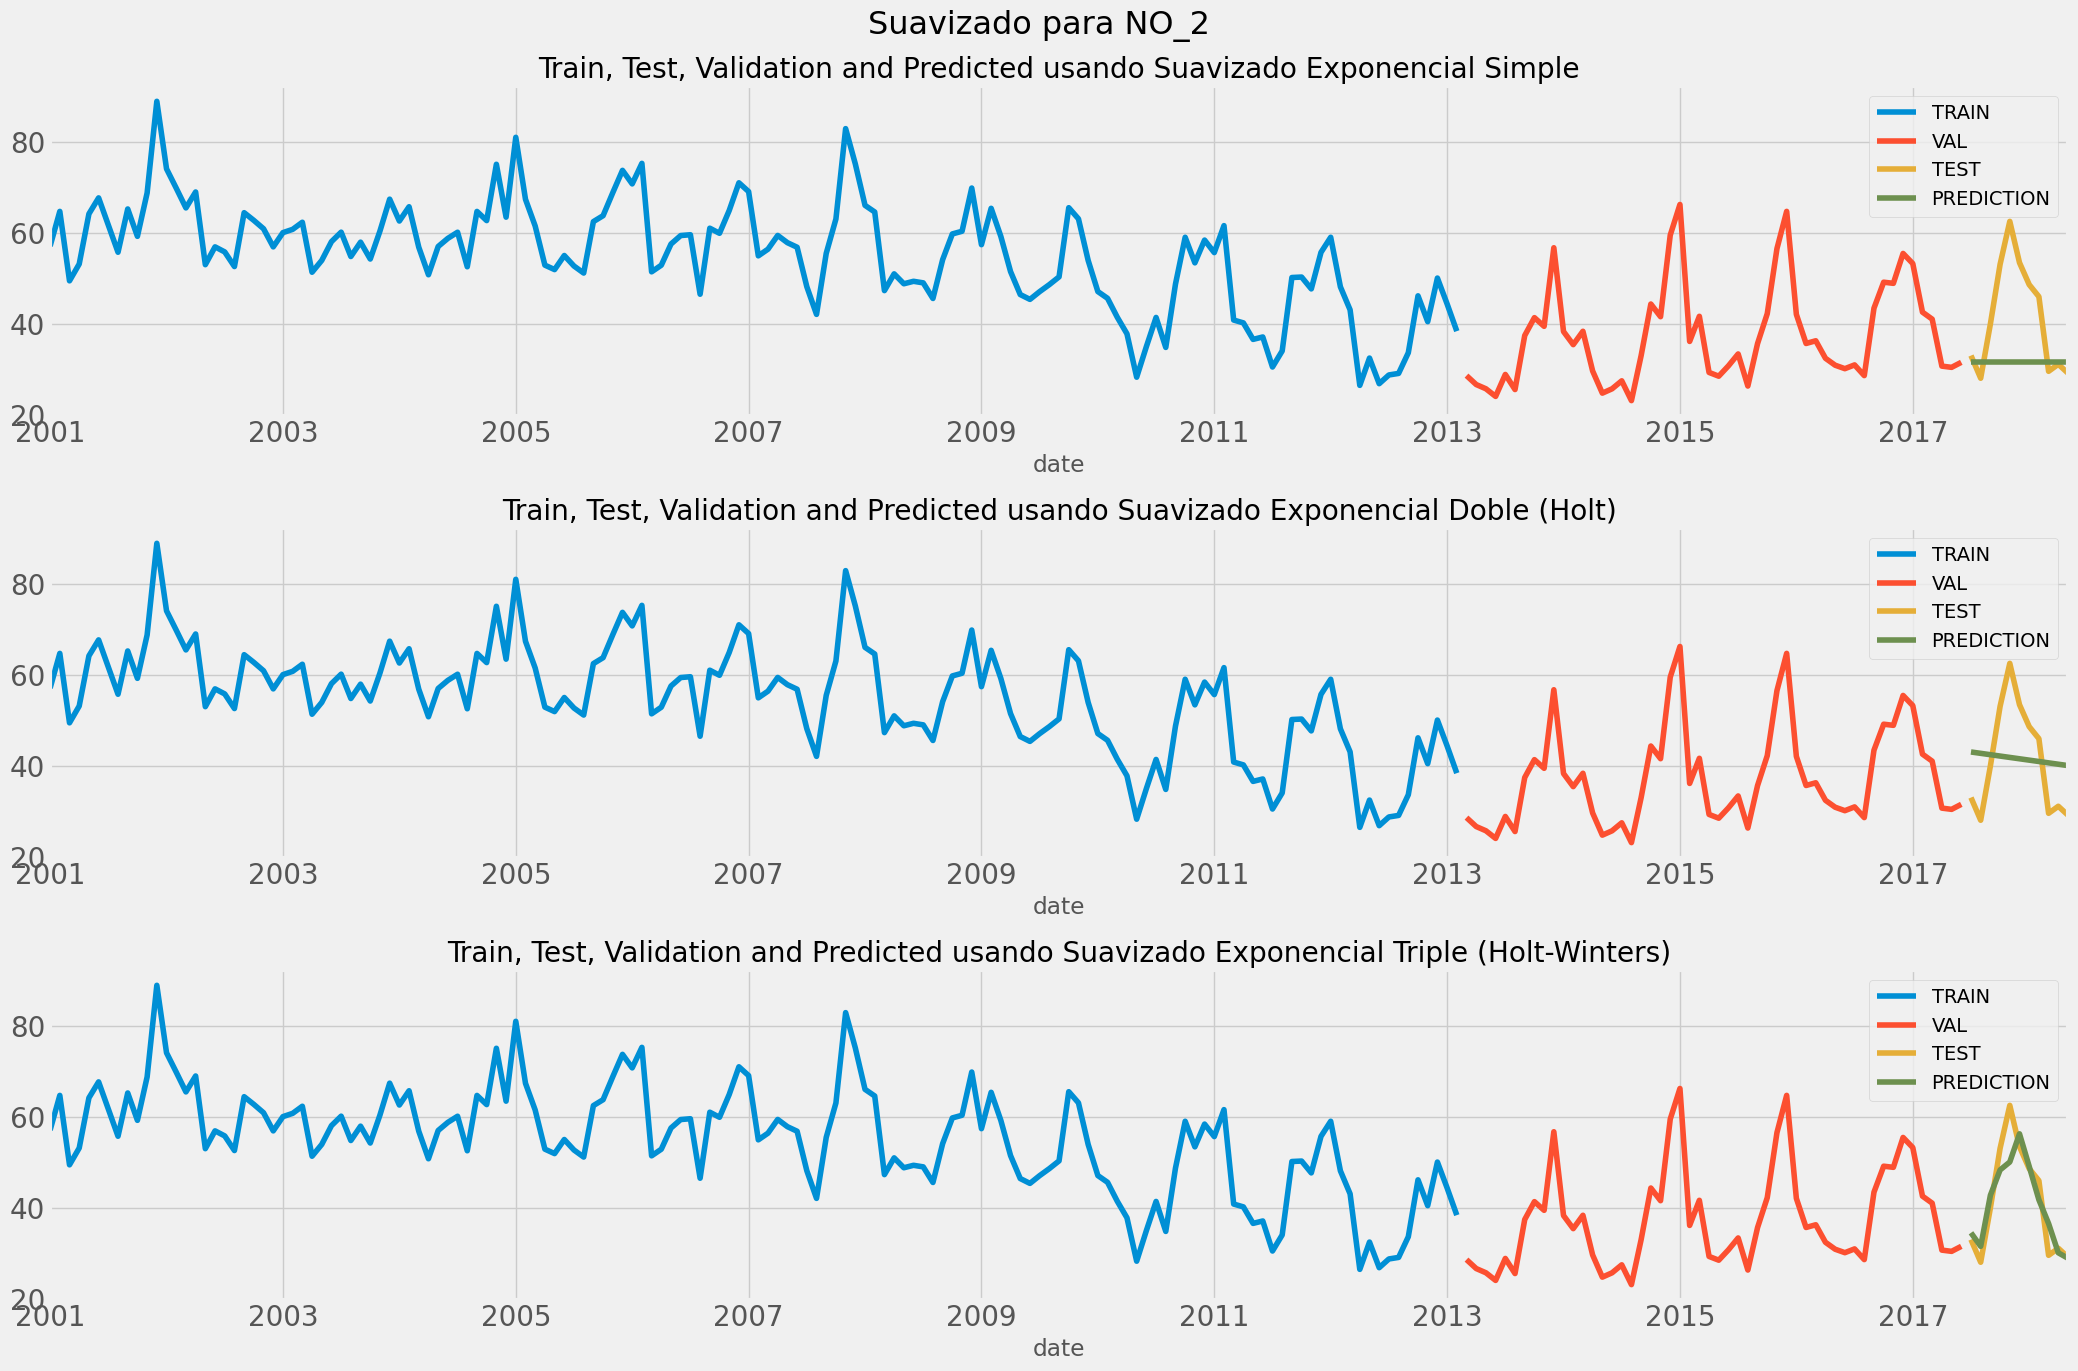

In [43]:
def plot_prediction(y_pred1, y_pred2, y_pred3, labels):
    plt.figure(figsize=(21,14), dpi=100)

    # suavizado simple
    plt.subplot(3, 1, 1)
    train_NO2["NO_2"].plot(legend=True, label="TRAIN")
    val_NO2["NO_2"].plot(legend=True, label="VAL")
    test_NO2["NO_2"].plot(legend=True, label="TEST")
    y_pred_SES.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test, Validation and Predicted usando " + labels[0])

    # suavizado doble 
    plt.subplot(3, 1, 2) 
    train_NO2["NO_2"].plot(legend=True, label="TRAIN")
    val_NO2["NO_2"].plot(legend=True, label="VAL")
    test_NO2["NO_2"].plot(legend=True, label="TEST")
    y_pred_H.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test, Validation and Predicted usando " + labels[1])

    # suavizado triple
    plt.subplot(3, 1, 3) 
    train_NO2["NO_2"].plot(legend=True, label="TRAIN")
    val_NO2["NO_2"].plot(legend=True, label="VAL")
    test_NO2["NO_2"].plot(legend=True, label="TEST")
    y_pred_HW.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test, Validation and Predicted usando " + labels[2])

    plt.suptitle("Suavizado para NO_2", size=23)
    plt.tight_layout()
    plt.show()

plot_prediction(y_pred_SES, y_pred_H, y_pred_HW, ["Suavizado Exponencial Simple", "Suavizado Exponencial Doble (Holt)", "Suavizado Exponencial Triple (Holt-Winters)"])

El gráfico muestra que los datos tienen tanto tendencia como estacionalidad, lo que hace que el suvizado exponencial triple (Holt-Winters) sea la mejor opción para la predicción. El suavizado simple y doble ofrecen un ajuste inferior porque no pueden modelar adecuadamente todos los componentes de la serie, en especial la estacionalidad. 

#### Análisis CO

In [44]:
# se define como train al 70% de los datos, como test el 25% y como validacion el 5%

train = round(len(monthly_CO) * 0.7)
val = round(len(monthly_CO) * 0.25 + train)
step_CO = round(len(monthly_CO) * 0.25)

train_CO = monthly_CO[:train]
val_CO = monthly_CO[train : val]
test_CO = monthly_CO[val:]

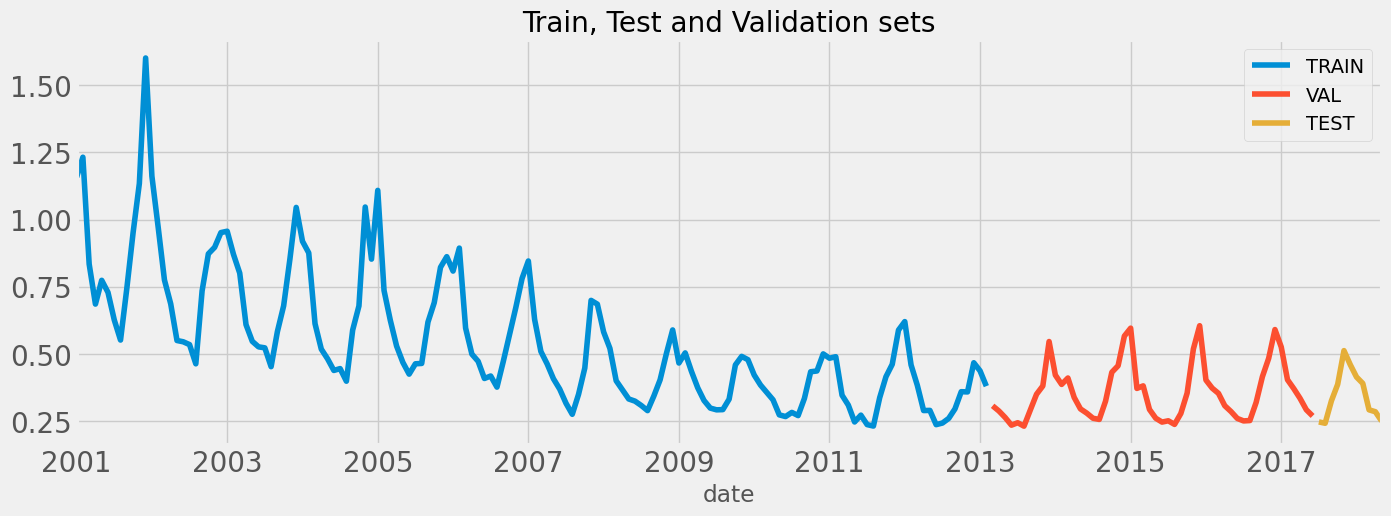

In [45]:
plt.figure(figsize=(15,5))
train_CO["CO"].plot(legend=True, label="TRAIN")
val_CO["CO"].plot(legend=True, label="VAL")
test_CO["CO"].plot(legend=True, label="TEST")    
plt.title("Train, Test and Validation sets")
plt.show()

#### Suavizado Exponencial Simple (SES) para CO

In [46]:
def plot_prediction(y_pred, label):
    plt.figure(figsize=(15,5), dpi=100)
    train_CO["CO"].plot(legend=True, label="TRAIN")
    val_CO["CO"].plot(legend=True, label="VAL")
    test_CO["CO"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test, Validation and Predicted usando "+label)
    plt.show()

In [47]:
alphas = np.arange(0.01, 1, 0.01)
# best_alpha, best_mae = ses_optimizer(train_CO, val_CO, alphas, step_CO)

In [48]:
# best_alpha: 0.1 best_mae: 0.0865
best_alpha = 0.1 
best_mae = 0.0865

In [49]:
train_val_CO = monthly_CO[:val]

ses_model = SimpleExpSmoothing(train_val_CO).fit(smoothing_level=best_alpha)
y_pred_SES = ses_model.forecast(11)


# Grafico suavizado simple
# plot_prediction(y_pred_SES, "SES para CO")

#### Suavizado Exponencial Doble (suavizado de Holt) para CO

In [50]:
alphas = np.arange(0.01, 1, 0.01)
betas = np.arange(0.01, 1, 0.01)

# best_alpha, best_beta, best_mae = des_optimizer(train_CO, val_CO, alphas, betas, step_CO)

In [51]:
# best_alpha: 0.01 best_beta: 0.28 best_mae: 0.0809
best_alpha = 0.01 
best_beta = 0.28 
best_mae = 0.0809

In [52]:
des_model = ExponentialSmoothing(train_val_CO, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred_H = des_model.forecast(11)

In [53]:
# grafico suavizado doble para CO 

# plot_prediction(y_pred_H, "Holt para NO")

#### Suavizado Exponencial Triple (suavizado de Holt-Winters) para CO

In [54]:
alphas = betas = gammas = np.arange(0.01, 1, 0.05)
abg = list(itertools.product(alphas, betas, gammas))

# best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train_CO, val_CO, abg, step_CO)

In [55]:
# best_alpha: 0.01 best_beta: 0.41 best_gamma: 0.36 best_mae: 0.0309
best_alpha = 0.01 
best_beta = 0.41 
best_gamma = 0.36 

In [56]:
tes_model = ExponentialSmoothing(train_val_CO, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred_HW = tes_model.forecast(11)

In [57]:
# Grafico  suavizado triple para CO

# plot_prediction(y_pred_HW, "Holt-Winters Aditivo para CO")

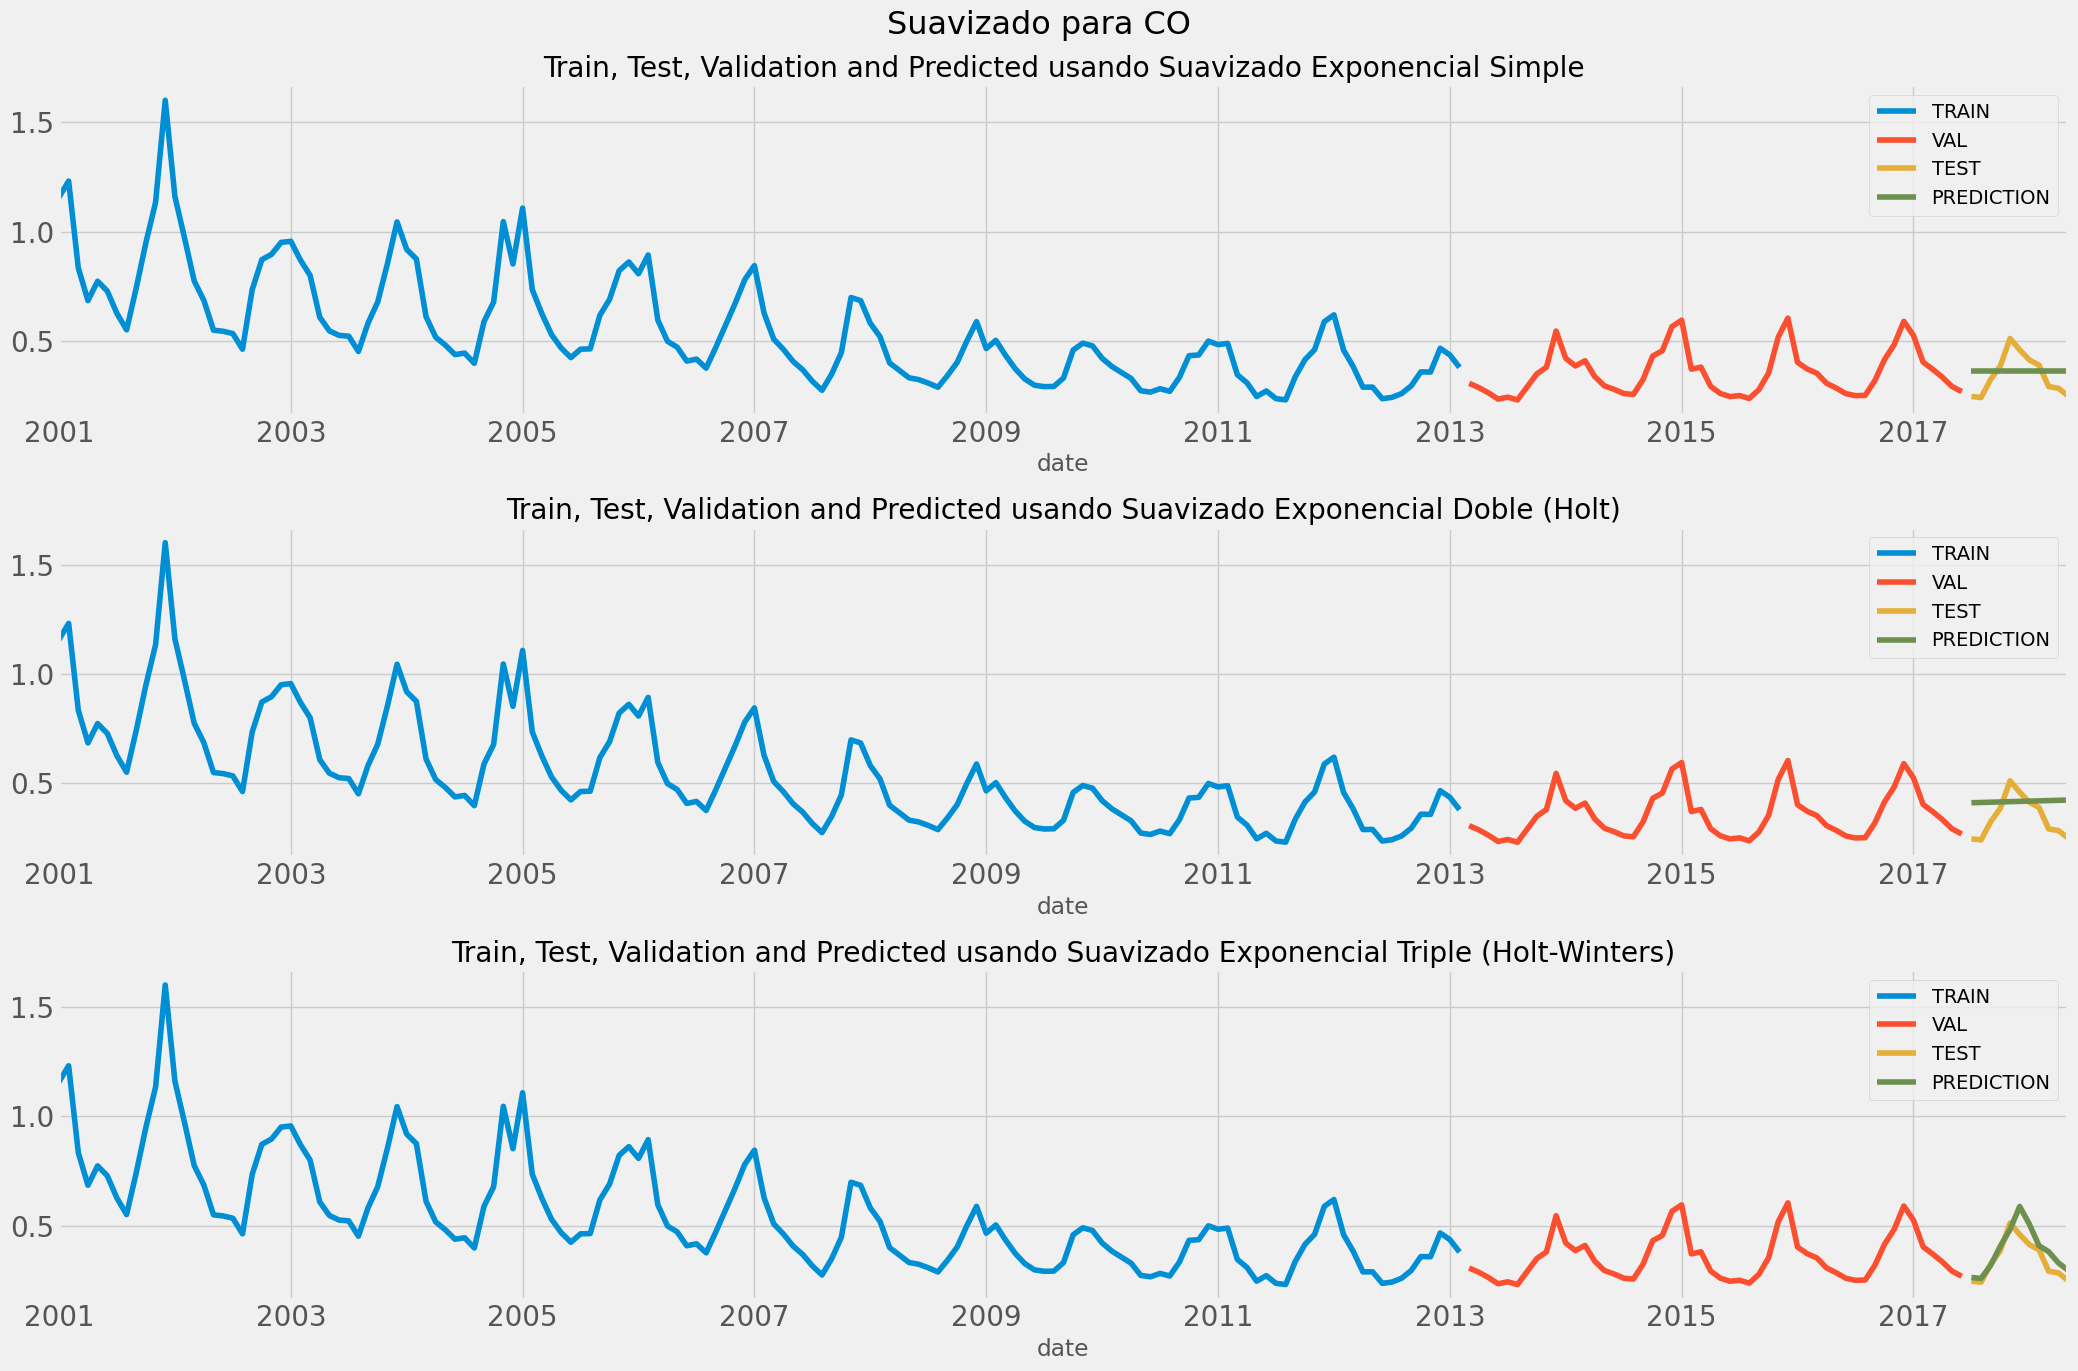

In [58]:
def plot_prediction(y_pred1, y_pred2, y_pred3, labels):
    plt.figure(figsize=(21,14), dpi=100)

    # suavizado simple
    plt.subplot(3, 1, 1)
    train_CO["CO"].plot(legend=True, label="TRAIN")
    val_CO["CO"].plot(legend=True, label="VAL")
    test_CO["CO"].plot(legend=True, label="TEST")
    y_pred_SES.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test, Validation and Predicted usando " + labels[0])

    # suavizado doble 
    plt.subplot(3, 1, 2) 
    train_CO["CO"].plot(legend=True, label="TRAIN")
    val_CO["CO"].plot(legend=True, label="VAL")
    test_CO["CO"].plot(legend=True, label="TEST")
    y_pred_H.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test, Validation and Predicted usando " + labels[1])

    # suavizado triple
    plt.subplot(3, 1, 3) 
    train_CO["CO"].plot(legend=True, label="TRAIN")
    val_CO["CO"].plot(legend=True, label="VAL")
    test_CO["CO"].plot(legend=True, label="TEST")
    y_pred_HW.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test, Validation and Predicted usando " + labels[2])

    # Ajuste del layout
    plt.suptitle("Suavizado para CO", size=23)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso con tres conjuntos de predicciones
plot_prediction(y_pred_SES, y_pred_H, y_pred_HW, ["Suavizado Exponencial Simple", "Suavizado Exponencial Doble (Holt)", "Suavizado Exponencial Triple (Holt-Winters)"])

En los datos de CO, se observa una clara estacionalidad además de la tendencia general, por lo que el suavizado exponencial triple (Holt-Winters) es el modelo más adecuado. Los métodos de suavizado simple y doble no pueden manejar la estacionalidad, lo que hace que sean insuficientes para este conjunto de datos.